# Commodity Price Prediction

In [1]:
import os
import time
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Conv1D, MaxPooling1D,
    LSTM, Bidirectional, TimeDistributed, Flatten,
    LayerNormalization, MultiHeadAttention, Concatenate,
    BatchNormalization
)
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l1_l2, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import keras_tuner as kt

import joblib

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False) 

## Understanding Data

In [3]:
def load_food_data(data_type='train'):
  base_path = 'Harga Bahan Pangan'
  folder_path = os.path.join(base_path, data_type)
  
  all_data = []
  
  food_files = os.listdir(folder_path)
  
  food_mapping = {
      'Bawang Merah.csv': 'Bawang Merah',
      'Bawang Putih Bonggol.csv': 'Bawang Putih Bonggol',
      'Beras Medium.csv': 'Beras Medium',
      'Beras Premium.csv': 'Beras Premium',
      'Cabai Merah Keriting.csv': 'Cabai Merah Keriting',
      'Cabai Rawit Merah.csv': 'Cabai Rawit Merah',
      'Daging Ayam Ras.csv': 'Daging Ayam Ras',
      'Daging Sapi Murni.csv': 'Daging Sapi Murni',
      'Gula Konsumsi.csv': 'Gula Konsumsi',
      'Minyak Goreng Curah.csv': 'Minyak Goreng Curah',
      'Minyak Goreng Kemasan Sederhana.csv': 'Minyak Goreng Kemasan Sederhana',
      'Telur Ayam Ras.csv': 'Telur Ayam Ras',
      'Tepung Terigu (Curah).csv': 'Tepung Terigu (Curah)'
  }
  
  provinces = [
      'Aceh', 'Bali', 'Banten', 'Bengkulu', 'DI Yogyakarta', 
      'DKI Jakarta', 'Gorontalo', 'Jambi', 'Jawa Barat', 
      'Jawa Tengah', 'Jawa Timur', 'Kalimantan Barat', 
      'Kalimantan Selatan', 'Kalimantan Tengah', 'Kalimantan Timur', 
      'Kalimantan Utara', 'Kepulauan Bangka Belitung', 'Kepulauan Riau', 
      'Lampung', 'Maluku', 'Maluku Utara', 'Nusa Tenggara Barat', 
      'Nusa Tenggara Timur', 'Papua', 'Papua Barat', 'Riau', 
      'Sulawesi Barat', 'Sulawesi Selatan', 'Sulawesi Tengah', 
      'Sulawesi Tenggara', 'Sulawesi Utara', 'Sumatera Barat', 
      'Sumatera Selatan', 'Sumatera Utara'
  ]
  
  for file_name in food_files:
      if file_name in food_mapping:
          food_name = food_mapping[file_name]
          file_path = os.path.join(folder_path, file_name)
          
          df = pd.read_csv(file_path)
          
          df_long = df.melt(
              id_vars=['Date'], 
              value_vars=provinces,
              var_name='province',
              value_name='price'
          )
          
          df_long['food_item'] = food_name
          
          all_data.append(df_long)
  
  combined_df = pd.concat(all_data, ignore_index=True)
  
  combined_df = combined_df.sort_values(['Date', 'province', 'food_item'])
  
  combined_df['Date'] = pd.to_datetime(combined_df['Date'])
  
  return combined_df

In [4]:
train_df = load_food_data('train')

test_df = load_food_data('test')

In [5]:
print(train_df.shape)
train_df.head(20)

(443768, 4)


,Date,province,price,food_item
0,2022-01-01,Aceh,28970.0,Bawang Merah
34136,2022-01-01,Aceh,27440.0,Bawang Putih Bonggol
68272,2022-01-01,Aceh,11030.0,Beras Medium
102408,2022-01-01,Aceh,12080.0,Beras Premium
136544,2022-01-01,Aceh,22360.0,Cabai Merah Keriting
170680,2022-01-01,Aceh,NaN,Cabai Rawit Merah
204816,2022-01-01,Aceh,30540.0,Daging Ayam Ras
238952,2022-01-01,Aceh,150930.0,Daging Sapi Murni
273088,2022-01-01,Aceh,13520.0,Gula Konsumsi
307224,2022-01-01,Aceh,NaN,Minyak Goreng Curah


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 443768 entries, 0 to 443767
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       443768 non-null  datetime64[ns]
 1   province   443768 non-null  object        
 2   price      422589 non-null  float64       
 3   food_item  443768 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 16.9+ MB


## EDA

In [7]:
print("\n=== Train Data Info ===")
print(f"Number of rows: {len(train_df)}")
print(f"Data period: {train_df['Date'].min().date()} to {train_df['Date'].max().date()}")
print(f"Number of unique food items: {train_df['food_item'].nunique()}")
print(f"Number of unique provinces: {train_df['province'].nunique()}")


=== Train Data Info ===
Number of rows: 443768
Data period: 2022-01-01 to 2024-09-30
Number of unique food items: 13
Number of unique provinces: 34


In [8]:
print("\n=== Test Data Info ===")
print(f"Number of rows: {len(test_df)}")
print(f"Data period: {test_df['Date'].min().date()} to {test_df['Date'].max().date()}")
print(f"Number of unique food items: {test_df['food_item'].nunique()}")
print(f"Number of unique provinces: {test_df['province'].nunique()}")


=== Test Data Info ===
Number of rows: 40664
Data period: 2024-10-01 to 2024-12-31
Number of unique food items: 13
Number of unique provinces: 34


In [9]:
print("\nPrice statistics per commodity (training):")
price_stats = train_df.groupby('food_item')['price'].agg(['min', 'max', 'mean', 'median', 'std','count'])
print(price_stats)


Price statistics per commodity (training):
                                     min       max           mean    median           std  count
food_item                                                                                       
Bawang Merah                     14810.0   85520.0   36557.443380   35210.0  10004.912170  32895
Bawang Putih Bonggol             18480.0   66050.0   35151.879921   35470.0   7836.923623  32895
Beras Medium                      9100.0   17000.0   12399.020520   12560.0   1551.386493  32895
Beras Premium                    10060.0   20000.0   14179.411765   14330.0   1868.977899  32895
Cabai Merah Keriting             16380.0  127910.0   48723.424541   46675.0  16040.381948  32892
Cabai Rawit Merah                14000.0  167210.0   57319.523691   55480.0  19227.107518  32101
Daging Ayam Ras                  23000.0   59160.0   37212.982216   36270.0   5909.623589  32895
Daging Sapi Murni                98300.0  180000.0  136376.815238  135240.0  12634.

In [10]:
print("\nFood item price statistics per province (training):\n")

provinces = train_df['province'].unique()

for province in provinces:
  print(f"=== {province.upper()} ===")
  
  province_data = train_df[train_df['province'] == province]
  
  stats = province_data.groupby('food_item')['price'].agg(
    ['min', 'max', 'mean', 'median', 'std', 'count']
  )
  
  print(stats)
  print("\n" + "-"*80 + "\n")


Food item price statistics per province (training):

=== ACEH ===
                                      min       max           mean    median           std  count
food_item                                                                                        
Bawang Merah                      21860.0   61030.0   34740.020683   33790.0   7681.229521    967
Bawang Putih Bonggol              23240.0   42400.0   33134.943123   35620.0   6250.974961    967
Beras Medium                      10570.0   13680.0   12013.753878   11560.0   1038.897964    967
Beras Premium                     11570.0   14870.0   13178.976215   12720.0   1147.989099    967
Cabai Merah Keriting              17970.0   98980.0   43133.753878   39570.0  16297.398600    967
Cabai Rawit Merah                 14000.0   75000.0   47662.522523   48990.0  10165.496693    222
Daging Ayam Ras                   27460.0   35680.0   30302.461220   29780.0   1569.694337    967
Daging Sapi Murni                146250.0  176340.0

## Handling Missing Values

In [11]:
print("\nMissing values in training data:")
print(train_df.isnull().sum())


Missing values in training data:
Date             0
province         0
price        21179
food_item        0
dtype: int64


In [12]:
print("\nMissing values analysis per province and food item (training data):\n")

missing_per_combination = train_df.groupby(['province', 'food_item'])['price'].apply(lambda x: x.isnull().sum()).reset_index(name='missing_count')

missing_per_combination = missing_per_combination[missing_per_combination['missing_count'] > 0]

print("Missing values per province and food item:")
print(missing_per_combination)


Missing values analysis per province and food item (training data):

Missing values per province and food item:
                      province                        food_item  missing_count
0                         Aceh                     Bawang Merah             37
1                         Aceh             Bawang Putih Bonggol             37
2                         Aceh                     Beras Medium             37
3                         Aceh                    Beras Premium             37
4                         Aceh             Cabai Merah Keriting             37
5                         Aceh                Cabai Rawit Merah            782
6                         Aceh                  Daging Ayam Ras             37
7                         Aceh                Daging Sapi Murni             37
8                         Aceh                    Gula Konsumsi             37
9                         Aceh              Minyak Goreng Curah            147
10                

In [13]:
print("\nSummary per province:")
province_summary = missing_per_combination.groupby('province')['missing_count'].sum().reset_index()
print(province_summary)


Summary per province:
                     province  missing_count
0                        Aceh           1336
1                        Bali            581
2                      Banten            591
3                    Bengkulu            593
4               DI Yogyakarta            578
5                 DKI Jakarta            592
6                   Gorontalo            660
7                       Jambi            604
8                  Jawa Barat            591
9                 Jawa Tengah            552
10                 Jawa Timur            565
11           Kalimantan Barat            578
12         Kalimantan Selatan            592
13          Kalimantan Tengah            578
14           Kalimantan Timur            618
15           Kalimantan Utara            767
16  Kepulauan Bangka Belitung            606
17             Kepulauan Riau            617
18                    Lampung            591
19                     Maluku            591
20               Maluku Utara   

In [14]:
print("\nSummary per food item:")
food_summary = missing_per_combination.groupby('food_item')['missing_count'].sum().reset_index()
print(food_summary)


Summary per food item:
                          food_item  missing_count
0                      Bawang Merah           1241
1              Bawang Putih Bonggol           1241
2                      Beras Medium           1241
3                     Beras Premium           1241
4              Cabai Merah Keriting           1244
5                 Cabai Rawit Merah           2035
6                   Daging Ayam Ras           1241
7                 Daging Sapi Murni           1245
8                     Gula Konsumsi           1241
9               Minyak Goreng Curah           5437
10  Minyak Goreng Kemasan Sederhana           1289
11                   Telur Ayam Ras           1241
12            Tepung Terigu (Curah)           1242


In [15]:
print("\nMissing values in test data:")
print(test_df.isnull().sum())


Missing values in test data:
Date         0
province     0
price        0
food_item    0
dtype: int64


### Handling with Missing Values

#### Merge with Google Trends Data

In [ ]:
food_to_trend_specific = {
    'Bawang Merah': 'bawang merah',
    'Bawang Putih Bonggol': 'bawang putih',
    'Cabai Merah Keriting': 'cabai merah',
    'Cabai Rawit Merah': 'cabai rawit',
    'Daging Ayam Ras': 'daging ayam',
    'Daging Sapi Murni': 'daging sapi',
    'Telur Ayam Ras': 'telur ayam',
    'Tepung Terigu (Curah)': 'tepung terigu'
}

food_to_trend_general = {
    'Bawang Merah': 'bawang',
    'Bawang Putih Bonggol': 'bawang',
    'Cabai Merah Keriting': 'cabai',
    'Cabai Rawit Merah': 'cabai',
    'Daging Ayam Ras': 'daging',
    'Daging Sapi Murni': 'daging',
    'Gula Konsumsi': 'gula',
    'Minyak Goreng Curah': 'minyak goreng',
    'Minyak Goreng Kemasan Sederhana': 'minyak goreng',
    'Telur Ayam Ras': 'telur',
    'Tepung Terigu (Curah)': 'tepung'
}

all_food_items = [
    'Bawang Merah', 'Bawang Putih Bonggol', 'Beras Medium', 'Beras Premium',
    'Cabai Merah Keriting', 'Cabai Rawit Merah', 'Daging Ayam Ras', 'Daging Sapi Murni',
    'Gula Konsumsi', 'Minyak Goreng Curah', 'Minyak Goreng Kemasan Sederhana',
    'Telur Ayam Ras', 'Tepung Terigu (Curah)'
]


def load_google_trends(province, food_item):
    specific_keyword = food_to_trend_specific.get(food_item)
    general_keyword = food_to_trend_general.get(food_item)

    df_spec, df_gen = None, None

    if specific_keyword:
        path_spec = f"Google Trend/{specific_keyword}/{province}.csv"
        if os.path.exists(path_spec):
            df_spec = pd.read_csv(path_spec)
            if specific_keyword in df_spec.columns:
                df_spec['Date'] = pd.to_datetime(df_spec['Date'])
                df_spec = df_spec[['Date', specific_keyword]].rename(columns={specific_keyword: 'trend_spec'})

    if general_keyword:
        path_gen = f"Google Trend/{general_keyword}/{province}.csv"
        if os.path.exists(path_gen):
            df_gen = pd.read_csv(path_gen)
            if general_keyword in df_gen.columns:
                df_gen['Date'] = pd.to_datetime(df_gen['Date'])
                df_gen = df_gen[['Date', general_keyword]].rename(columns={general_keyword: 'trend_gen'})

    if df_spec is None and df_gen is None:
        return None

    if df_spec is None:
        return df_gen.rename(columns={'trend_gen': food_item})
    if df_gen is None:
        return df_spec.rename(columns={'trend_spec': food_item})

    df_combined = pd.merge(df_spec, df_gen, on='Date', how='outer')

    def choose_value(row):
        spec_val = row['trend_spec']
        gen_val = row['trend_gen']
        if pd.notna(spec_val) and spec_val != 0:
            return spec_val
        elif pd.notna(gen_val):
            return gen_val
        return None

    df_combined[food_item] = df_combined.apply(choose_value, axis=1)

    return df_combined[['Date', food_item]]



trend_dfs = []

provinces = train_df['province'].unique()
for province in tqdm(provinces, desc="Proses Provinsi"):
    for food_item in all_food_items:
        trend_data = load_google_trends(province, food_item)

        if trend_data is not None:
            trend_data['province'] = province
            trend_data['food_item'] = food_item
            trend_dfs.append(trend_data)

if trend_dfs:
    trend_df = pd.concat(trend_dfs)
    train_df = pd.merge(train_df, trend_df, on=['Date', 'province', 'food_item'], how='left')
    print("Google Trends berhasil diintegrasikan!")
else:
    print("Tidak ada data Google Trends yang ditemukan")

Proses Provinsi: 100%|██████████| 34/34 [00:09<00:00,  3.69it/s]
C:\Users\Kelvin Jonathan\AppData\Local\Temp\ipykernel_17220\2002270272.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trend_df = pd.concat(trend_dfs)


Google Trends berhasil diintegrasikan!


In [17]:
train_df.head(20)

,Date,province,price,food_item,Bawang Merah,Bawang Putih Bonggol,Cabai Merah Keriting,Cabai Rawit Merah,Daging Ayam Ras,Daging Sapi Murni,Gula Konsumsi,Minyak Goreng Curah,Minyak Goreng Kemasan Sederhana,Telur Ayam Ras,Tepung Terigu (Curah)
0,2022-01-01,Aceh,28970.0,Bawang Merah,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01,Aceh,27440.0,Bawang Putih Bonggol,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-01,Aceh,11030.0,Beras Medium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-01,Aceh,12080.0,Beras Premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-01,Aceh,22360.0,Cabai Merah Keriting,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2022-01-01,Aceh,NaN,Cabai Rawit Merah,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2022-01-01,Aceh,30540.0,Daging Ayam Ras,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
7,2022-01-01,Aceh,150930.0,Daging Sapi Murni,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
8,2022-01-01,Aceh,13520.0,Gula Konsumsi,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
9,2022-01-01,Aceh,NaN,Minyak Goreng Curah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [18]:
train_df[train_df['Date'] == '2022-07-26']

,Date,province,price,food_item,Bawang Merah,Bawang Putih Bonggol,Cabai Merah Keriting,Cabai Rawit Merah,Daging Ayam Ras,Daging Sapi Murni,Gula Konsumsi,Minyak Goreng Curah,Minyak Goreng Kemasan Sederhana,Telur Ayam Ras,Tepung Terigu (Curah)
91052,2022-07-26,Aceh,49400.0,Bawang Merah,49.509153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91053,2022-07-26,Aceh,24610.0,Bawang Putih Bonggol,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91054,2022-07-26,Aceh,10770.0,Beras Medium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91055,2022-07-26,Aceh,11780.0,Beras Premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91056,2022-07-26,Aceh,92960.0,Cabai Merah Keriting,NaN,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91057,2022-07-26,Aceh,NaN,Cabai Rawit Merah,NaN,NaN,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91058,2022-07-26,Aceh,29550.0,Daging Ayam Ras,NaN,NaN,NaN,NaN,9.041152,NaN,NaN,NaN,NaN,NaN,NaN
91059,2022-07-26,Aceh,151620.0,Daging Sapi Murni,NaN,NaN,NaN,NaN,NaN,9.041152,NaN,NaN,NaN,NaN,NaN
91060,2022-07-26,Aceh,14550.0,Gula Konsumsi,NaN,NaN,NaN,NaN,NaN,NaN,37.380357,NaN,NaN,NaN,NaN
91061,2022-07-26,Aceh,13040.0,Minyak Goreng Curah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN


#### Merge with Global Commodity Price Data

In [ ]:
def parse_volume(vol_str):
    """Konversi string volume seperti '189.29K' menjadi float (189290.0)"""
    if isinstance(vol_str, str):
        mult = {'K': 1e3, 'M': 1e6, 'B': 1e9}
        if vol_str[-1] in mult:
            return float(vol_str[:-1].replace(',', '')) * mult[vol_str[-1]]
        else:
            return float(vol_str.replace(',', ''))
    return vol_str  

def clean_price_column(col):
    """Hapus tanda kutip dan koma, lalu konversi ke float"""
    return col.replace({'"': '', ',': ''}, regex=True).astype(float)

food_to_commodity = {
    'Minyak Goreng Curah': 'Palm Oil',
    'Minyak Goreng Kemasan Sederhana': 'Palm Oil',
    'Tepung Terigu (Curah)': 'Wheat',
    'Gula Konsumsi': 'Sugar',
    'Beras Medium': 'Wheat',  
    'Beras Premium': 'Wheat',  
    'Daging Ayam Ras': 'Crude Oil',  
    'Daging Sapi Murni': 'Crude Oil',  
    'Telur Ayam Ras': 'Crude Oil'  
}

commodity_data = []
commodity_files = {
    "Crude Oil": "Crude Oil WTI Futures Historical Data.csv",
    "Natural Gas": "Natural Gas Futures Historical Data.csv",
    "Coal": "Newcastle Coal Futures Historical Data.csv",
    "Palm Oil": "Palm Oil Futures Historical Data.csv",
    "Sugar": "US Sugar 11 Futures Historical Data.csv",
    "Wheat": "US Wheat Futures Historical Data.csv"
}

for comm_name, file_name in commodity_files.items():
    file_path = f"Global Commodity Price/{file_name}"
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)

        for col in ['Price', 'Open', 'High', 'Low']:
            if col in df.columns:
                df[col] = clean_price_column(df[col].astype(str))

        df['Date'] = pd.to_datetime(df['Date'])

        change_col = 'Change %'
        if change_col in df.columns:
            df[change_col] = df[change_col].str.replace('%', '', regex=False).astype(float) / 100

        if 'Vol.' in df.columns:
            df['Vol.'] = df['Vol.'].apply(parse_volume)

        base = comm_name.lower().replace(" ", "_")
        rename_dict = {
            'Price': f'price_{base}',
            'Open': f'open_{base}',
            'High': f'high_{base}',
            'Low': f'low_{base}',
            'Vol.': f'vol_{base}',
            'Change %': f'change_pct_{base}'
        }
        df = df.rename(columns=rename_dict)

        commodity_data.append(df)

commodity_df = pd.concat(commodity_data, ignore_index=True)
commodity_df = commodity_df.groupby('Date').first().reset_index()

train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = pd.merge(train_df, commodity_df, on='Date', how='left')

In [20]:
train_df[train_df['Date'] == '2024-09-30']

,Date,province,price,food_item,Bawang Merah,Bawang Putih Bonggol,Cabai Merah Keriting,Cabai Rawit Merah,Daging Ayam Ras,Daging Sapi Murni,Gula Konsumsi,Minyak Goreng Curah,Minyak Goreng Kemasan Sederhana,Telur Ayam Ras,Tepung Terigu (Curah),price_crude_oil,open_crude_oil,high_crude_oil,low_crude_oil,vol_crude_oil,change_pct_crude_oil,price_natural_gas,open_natural_gas,high_natural_gas,low_natural_gas,vol_natural_gas,change_pct_natural_gas,price_coal,open_coal,high_coal,low_coal,vol_coal,change_pct_coal,price_palm_oil,open_palm_oil,high_palm_oil,low_palm_oil,vol_palm_oil,change_pct_palm_oil,price_sugar,open_sugar,high_sugar,low_sugar,vol_sugar,change_pct_sugar,price_wheat,open_wheat,high_wheat,low_wheat,vol_wheat,change_pct_wheat
443326,2024-09-30,Aceh,28960.0,Bawang Merah,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.77,68.08,68.83,67.14,189290.0,0.0015,3.345,3.302,3.368,3.274,67900.0,0.0124,145.1,149.0,149.0,145.0,10.0,0.0383,4124.0,4150.0,4163.0,4120.0,1230.0,-0.0084,22.67,22.7,22.84,22.1,18860.0,-0.0053,584.0,579.75,590.75,575.5,58870.0,0.0069
443327,2024-09-30,Aceh,39110.0,Bawang Putih Bonggol,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.77,68.08,68.83,67.14,189290.0,0.0015,3.345,3.302,3.368,3.274,67900.0,0.0124,145.1,149.0,149.0,145.0,10.0,0.0383,4124.0,4150.0,4163.0,4120.0,1230.0,-0.0084,22.67,22.7,22.84,22.1,18860.0,-0.0053,584.0,579.75,590.75,575.5,58870.0,0.0069
443328,2024-09-30,Aceh,13470.0,Beras Medium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.77,68.08,68.83,67.14,189290.0,0.0015,3.345,3.302,3.368,3.274,67900.0,0.0124,145.1,149.0,149.0,145.0,10.0,0.0383,4124.0,4150.0,4163.0,4120.0,1230.0,-0.0084,22.67,22.7,22.84,22.1,18860.0,-0.0053,584.0,579.75,590.75,575.5,58870.0,0.0069
443329,2024-09-30,Aceh,14660.0,Beras Premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.77,68.08,68.83,67.14,189290.0,0.0015,3.345,3.302,3.368,3.274,67900.0,0.0124,145.1,149.0,149.0,145.0,10.0,0.0383,4124.0,4150.0,4163.0,4120.0,1230.0,-0.0084,22.67,22.7,22.84,22.1,18860.0,-0.0053,584.0,579.75,590.75,575.5,58870.0,0.0069
443330,2024-09-30,Aceh,25510.0,Cabai Merah Keriting,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.77,68.08,68.83,67.14,189290.0,0.0015,3.345,3.302,3.368,3.274,67900.0,0.0124,145.1,149.0,149.0,145.0,10.0,0.0383,4124.0,4150.0,4163.0,4120.0,1230.0,-0.0084,22.67,22.7,22.84,22.1,18860.0,-0.0053,584.0,579.75,590.75,575.5,58870.0,0.0069
443331,2024-09-30,Aceh,NaN,Cabai Rawit Merah,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.77,68.08,68.83,67.14,189290.0,0.0015,3.345,3.302,3.368,3.274,67900.0,0.0124,145.1,149.0,149.0,145.0,10.0,0.0383,4124.0,4150.0,4163.0,4120.0,1230.0,-0.0084,22.67,22.7,22.84,22.1,18860.0,-0.0053,584.0,579.75,590.75,575.5,58870.0,0.0069
443332,2024-09-30,Aceh,30080.0,Daging Ayam Ras,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,67.77,68.08,68.83,67.14,189290.0,0.0015,3.345,3.302,3.368,3.274,67900.0,0.0124,145.1,149.0,149.0,145.0,10.0,0.0383,4124.0,4150.0,4163.0,4120.0,1230.0,-0.0084,22.67,22.7,22.84,22.1,18860.0,-0.0053,584.0,579.75,590.75,575.5,58870.0,0.0069
443333,2024-09-30,Aceh,152990.0,Daging Sapi Murni,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,67.77,68.08,68.83,67.14,189290.0,0.0015,3.345,3.302,3.368,3.274,67900.0,0.0124,145.1,149.0,149.0,145.0,10.0,0.0383,4124.0,4150.0,4163.0,4120.0,1230.0,-0.0084,22.67,22.7,22.84,22.1,18860.0,-0.0053,584.0,579.75,590.75,575.5,58870.0,0.0069
443334,2024-09-30,Aceh,18030.0,Gula Konsumsi,NaN,NaN,NaN,NaN,NaN,NaN,44.000000,NaN,NaN,NaN,NaN,67.77,68.08,68.83,67.14,189290.0,0.0015,3.345,3.302,3.368,3.274,67900.0,0.0124,145.1,149.0,149.0,145.0,10.0,0.0383,4124.0,4150.0,4163.0,4120.0,1230.0,-0.0084,22.67,22.7,22.84,22.1,18860.0,-0.0053,584.0,579.75,590.75,575.5,58870.0,0.0069
443335,2024-09-30,Aceh,15670.0,Minyak Goreng Curah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.77,68.08,68.83,67.14,189290.0,0.0015,3.345,3.302,3.368,3.274,67900.0,0.0124,145.1,149.0,149.0,145.0,10.0,0.0383,4124.0,4150.0,4163.0,4120.0,1230.0,-0.0084,22.67,22.7,22.84,22

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443768 entries, 0 to 443767
Data columns (total 51 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Date                             443768 non-null  datetime64[ns]
 1   province                         443768 non-null  object        
 2   price                            422589 non-null  float64       
 3   food_item                        443768 non-null  object        
 4   Bawang Merah                     31124 non-null   float64       
 5   Bawang Putih Bonggol             31124 non-null   float64       
 6   Cabai Merah Keriting             20812 non-null   float64       
 7   Cabai Rawit Merah                20814 non-null   float64       
 8   Daging Ayam Ras                  33043 non-null   float64       
 9   Daging Sapi Murni                33043 non-null   float64       
 10  Gula Konsumsi                    33498 non-n

#### Merge with Mata Uang Data

In [ ]:
currency_files = {
    "MYRUSD": "MYRUSD=X.csv",
    "SGDUSD": "SGDUSD=X.csv",
    "THBUSD": "THBUSD=X.csv",
    "USDIDR": "USDIDR=X.csv"
}

currency_df = pd.DataFrame()

for currency, file_name in currency_files.items():
    file_path = f"Mata Uang/{file_name}"
    if os.path.exists(file_path):
        df_curr = pd.read_csv(file_path)

        df_curr['Date'] = pd.to_datetime(df_curr['Date'])

        columns_to_clean = ['Close', 'Open', 'High', 'Low', 'Volume']
        
        for col in columns_to_clean:
            if col in df_curr.columns:
                df_curr[col] = (
                    df_curr[col]
                    .astype(str)
                    .str.replace(',', '', regex=False)
                    .str.replace('"', '', regex=False)
                    .replace('-', '0')  
                    .astype(float)
                )

        df_curr = df_curr.rename(columns={
            'Close': f'price_{currency}',
            'Open': f'open_{currency}',
            'High': f'high_{currency}',
            'Low': f'low_{currency}',
            'Volume': f'volume_{currency}'
        })

        df_curr = df_curr[['Date', f'price_{currency}', f'open_{currency}',
                           f'high_{currency}', f'low_{currency}', f'volume_{currency}']]

        currency_df = pd.merge(currency_df, df_curr, on='Date', how='outer') if not currency_df.empty else df_curr

if not currency_df.empty:
    train_df['Date'] = pd.to_datetime(train_df['Date']) 
    train_df = pd.merge(train_df, currency_df, on='Date', how='left')


In [23]:
train_df[train_df['Date'] == '2022-01-03']

,Date,province,price,food_item,Bawang Merah,Bawang Putih Bonggol,Cabai Merah Keriting,Cabai Rawit Merah,Daging Ayam Ras,Daging Sapi Murni,Gula Konsumsi,Minyak Goreng Curah,Minyak Goreng Kemasan Sederhana,Telur Ayam Ras,Tepung Terigu (Curah),price_crude_oil,open_crude_oil,high_crude_oil,low_crude_oil,vol_crude_oil,change_pct_crude_oil,price_natural_gas,open_natural_gas,high_natural_gas,low_natural_gas,vol_natural_gas,change_pct_natural_gas,price_coal,open_coal,high_coal,low_coal,vol_coal,change_pct_coal,price_palm_oil,open_palm_oil,high_palm_oil,low_palm_oil,vol_palm_oil,change_pct_palm_oil,price_sugar,open_sugar,high_sugar,low_sugar,vol_sugar,change_pct_sugar,price_wheat,open_wheat,high_wheat,low_wheat,vol_wheat,change_pct_wheat,price_MYRUSD,open_MYRUSD,high_MYRUSD,low_MYRUSD,volume_MYRUSD,price_SGDUSD,open_SGDUSD,high_SGDUSD,low_SGDUSD,volume_SGDUSD,price_THBUSD,open_THBUSD,high_THBUSD,low_THBUSD,volume_THBUSD,price_USDIDR,open_USDIDR,high_USDIDR,low_USDIDR,volume_USDIDR
884,2022-01-03,Aceh,28970.0,Bawang Merah,42.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.85,75.53,76.18,74.01,112230.0,0.013,3.678,3.554,3.709,3.5,52870.0,0.034,157.5,157.5,157.5,157.5,0.0,-0.0713,5259.0,5260.0,5300.0,5258.0,1020.0,0.0194,18.74,18.94,19.01,18.68,20400.0,-0.0074,758.0,774.0,782.25,752.75,42120.0,-0.0165,0.239521,0.240038,0.240038,0.239722,0.0,0.74173,0.741713,0.742115,0.738531,0.0,0.030201,0.030189,0.030216,0.029976,0.0,14215.0,14246.0,14301.299805,14207.5,0.0
885,2022-01-03,Aceh,27970.0,Bawang Putih Bonggol,NaN,42.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.85,75.53,76.18,74.01,112230.0,0.013,3.678,3.554,3.709,3.5,52870.0,0.034,157.5,157.5,157.5,157.5,0.0,-0.0713,5259.0,5260.0,5300.0,5258.0,1020.0,0.0194,18.74,18.94,19.01,18.68,20400.0,-0.0074,758.0,774.0,782.25,752.75,42120.0,-0.0165,0.239521,0.240038,0.240038,0.239722,0.0,0.74173,0.741713,0.742115,0.738531,0.0,0.030201,0.030189,0.030216,0.029976,0.0,14215.0,14246.0,14301.299805,14207.5,0.0
886,2022-01-03,Aceh,10970.0,Beras Medium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.85,75.53,76.18,74.01,112230.0,0.013,3.678,3.554,3.709,3.5,52870.0,0.034,157.5,157.5,157.5,157.5,0.0,-0.0713,5259.0,5260.0,5300.0,5258.0,1020.0,0.0194,18.74,18.94,19.01,18.68,20400.0,-0.0074,758.0,774.0,782.25,752.75,42120.0,-0.0165,0.239521,0.240038,0.240038,0.239722,0.0,0.74173,0.741713,0.742115,0.738531,0.0,0.030201,0.030189,0.030216,0.029976,0.0,14215.0,14246.0,14301.299805,14207.5,0.0
887,2022-01-03,Aceh,11990.0,Beras Premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.85,75.53,76.18,74.01,112230.0,0.013,3.678,3.554,3.709,3.5,52870.0,0.034,157.5,157.5,157.5,157.5,0.0,-0.0713,5259.0,5260.0,5300.0,5258.0,1020.0,0.0194,18.74,18.94,19.01,18.68,20400.0,-0.0074,758.0,774.0,782.25,752.75,42120.0,-0.0165,0.239521,0.240038,0.240038,0.239722,0.0,0.74173,0.741713,0.742115,0.738531,0.0,0.030201,0.030189,0.030216,0.029976,0.0,14215.0,14246.0,14301.299805,14207.5,0.0
888,2022-01-03,Aceh,22050.0,Cabai Merah Keriting,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.85,75.53,76.18,74.01,112230.0,0.013,3.678,3.554,3.709,3.5,52870.0,0.034,157.5,157.5,157.5,157.5,0.0,-0.0713,5259.0,5260.0,5300.0,5258.0,1020.0,0.0194,18.74,18.94,19.01,18.68,20400.0,-0.0074,758.0,774.0,782.25,752.75,42120.0,-0.0165,0.239521,0.240038,0.240038,0.239722,0.0,0.74173,0.741713,0.742115,0.738531,0.0,0.030201,0.030189,0.030216,0.029976,0.0,14215.0,14246.0,14301.299805,14207.5,0.0
889,2022-01-03,Aceh,NaN,Cabai Rawit Merah,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.85,75.53,76.18,74.01,112230.0,0.013,3.678,3.554,3.709,3.5,52870.0,0.034,157.5,157.5,157.5,157.5,0.0,-0.0713,5259.0,5260.0,5300.0,5258.0,1020.0,0.0194,18.74,18.94,19.01,18.68,20400.0,-0.0074,758.0,774.0,782.25,752.75,42120.0,-0.0165,0.239521,0.240038,0.240038,0.239722,0.0,0.74173,0.741713,0.742115,0.738531,0.0,0.030201,0.030189,0.030216,0.029976,0.0,14215.0,14246.0,14301.299805,14207.5,0.0
890,2022-01-03,Aceh,30980.0,Daging Ayam Ras,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,

#### Impute with Model

In [ ]:
def impute_province_data(province_df, province_name):
    print(f"\nProcessing province: {province_name}")
    print(f"Number of rows: {len(province_df)}")
    missing_count = province_df['price'].isnull().sum()
    print(f"Initial missing values: {missing_count}")
    
    if missing_count == 0:
        province_df['price_final'] = province_df['price']
        print("No missing values. Skipping imputation...")
        return province_df
    
    province_df['Date'] = pd.to_datetime(province_df['Date'])
    
    province_df['day_of_year'] = province_df['Date'].dt.dayofyear
    province_df['month'] = province_df['Date'].dt.month
    province_df['year'] = province_df['Date'].dt.year
    province_df['weekday'] = province_df['Date'].dt.weekday
    province_df['week'] = province_df['Date'].dt.isocalendar().week
    
    food_map = {f: i for i, f in enumerate(province_df['food_item'].unique())}
    province_df['food_code'] = province_df['food_item'].map(food_map)
    
    feature_columns = [
        'day_of_year', 'month', 'year', 'weekday', 'week', 'food_code',

        'Bawang Merah',
        'Bawang Putih Bonggol',
        'Cabai Merah Keriting',
        'Cabai Rawit Merah',
        'Daging Ayam Ras',
        'Daging Sapi Murni',
        'Gula Konsumsi',
        'Minyak Goreng Curah',
        'Minyak Goreng Kemasan Sederhana',
        'Telur Ayam Ras',
        'Tepung Terigu (Curah)',

        'price_crude_oil', 'open_crude_oil', 'high_crude_oil', 'low_crude_oil',
        'vol_crude_oil', 'change_pct_crude_oil',

        'price_natural_gas', 'open_natural_gas', 'high_natural_gas', 'low_natural_gas',
        'vol_natural_gas', 'change_pct_natural_gas',

        'price_coal', 'open_coal', 'high_coal', 'low_coal',
        'vol_coal', 'change_pct_coal',

        'price_palm_oil', 'open_palm_oil', 'high_palm_oil', 'low_palm_oil',
        'vol_palm_oil', 'change_pct_palm_oil',

        'price_sugar', 'open_sugar', 'high_sugar', 'low_sugar',
        'vol_sugar', 'change_pct_sugar',

        'price_wheat', 'open_wheat', 'high_wheat', 'low_wheat',
        'vol_wheat', 'change_pct_wheat',

        'price_MYRUSD', 'open_MYRUSD', 'high_MYRUSD', 'low_MYRUSD', 'volume_MYRUSD',
        'price_SGDUSD', 'open_SGDUSD', 'high_SGDUSD', 'low_SGDUSD', 'volume_SGDUSD',
        'price_THBUSD', 'open_THBUSD', 'high_THBUSD', 'low_THBUSD', 'volume_THBUSD',
        'price_USDIDR', 'open_USDIDR', 'high_USDIDR', 'low_USDIDR', 'volume_USDIDR'
    ]
    
    available_features = [col for col in feature_columns if col in province_df.columns]
    print(f"Features used: {len(available_features)}")
    
    model_df = province_df[available_features + ['price']].copy()
    
    known_data = model_df[model_df['price'].notnull()]
    unknown_data = model_df[model_df['price'].isnull()]
    
    print(f"Known rows: {len(known_data)} | Rows to impute: {len(unknown_data)}")
    
    if len(known_data) == 0:
        print("Warning: No known price data! Using fallback method...")
        province_df['price_final'] = province_df.groupby('food_item')['price'].transform(
            lambda x: x.fillna(x.median())
        )
        return province_df
    
    print("Training RandomForest model...")
    X_train = known_data[available_features]
    y_train = known_data['price']
    
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=5,
        n_jobs=-1,  
        random_state=42
    )
    model.fit(X_train, y_train)
    
    print("Predicting missing values...")
    if len(unknown_data) > 0:
        X_missing = unknown_data[available_features]
        predicted = model.predict(X_missing)
        
        province_df.loc[unknown_data.index, 'price_imputed'] = predicted
    
    province_df['price_final'] = province_df['price'].combine_first(province_df['price_imputed'])
    
    missing_final = province_df['price_final'].isnull().sum()
    print(f"Final missing values: {missing_final}")
    
    return province_df

In [25]:
os.makedirs("province_data", exist_ok=True)
os.makedirs("imputed_data", exist_ok=True)

In [26]:
all_provinces = train_df['province'].unique()
print(f"Total province: {len(all_provinces)}")

Total province: 34


In [27]:
for province in all_provinces:
    province_filename = f"province_data/{province.replace(' ', '_')}.csv"
    if not os.path.exists(province_filename):
        province_df = train_df[train_df['province'] == province]
        province_df.to_csv(province_filename, index=False)
        print(f"Saved: {province_filename}")

In [ ]:
province_files = [f for f in os.listdir("province_data") if f.endswith(".csv")]

progress_file = "imputation_progress.csv"
if not os.path.exists(progress_file):
    pd.DataFrame(columns=['province', 'status', 'timestamp']).to_csv(progress_file, index=False)

for p_file in tqdm(province_files, desc="Available Provinces"):
    province_name = p_file.replace(".csv", "").replace("_", " ")
    
    progress_df = pd.read_csv(progress_file)
    if province_name in progress_df['province'].values:
        print(f"\n{province_name} has already been processed. Skipping...")
        continue
    
    try:
        file_path = f"province_data/{p_file}"
        province_df = pd.read_csv(file_path)
        
        imputed_df = impute_province_data(province_df, province_name)
        
        output_path = f"imputed_data/{p_file}"
        imputed_df.to_csv(output_path, index=False)
        
        new_progress = pd.DataFrame({
            'province': [province_name],
            'status': ['Selesai'],
            'timestamp': [pd.Timestamp.now()]
        })
        progress_df = pd.concat([progress_df, new_progress])
        progress_df.to_csv(progress_file, index=False)
        print(f"Progress saved for {province_name}")
        
    except Exception as e:
        error_progress = pd.DataFrame({
            'province': [province_name],
            'status': [f"Error: {str(e)}"],
            'timestamp': [pd.Timestamp.now()]
        })
        progress_df = pd.concat([progress_df, error_progress])
        progress_df.to_csv(progress_file, index=False)
        print(f"Error in province {province_name}: {str(e)}")

Available Provinces:   0%|          | 0/34 [00:00<?, ?it/s]


Processing province: Aceh
Number of rows: 13052
Initial missing values: 1336
Features used: 73
Known rows: 11716 | Rows to impute: 1336
Training RandomForest model...
Predicting missing values...
Final missing values: 0


C:\Users\Kelvin Jonathan\AppData\Local\Temp\ipykernel_17220\4122840278.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  progress_df = pd.concat([progress_df, new_progress])
Available Provinces:   3%|▎         | 1/34 [00:11<06:21, 11.55s/it]

Progress saved for Aceh

Processing province: Bali
Number of rows: 13052
Initial missing values: 581
Features used: 73
Known rows: 12471 | Rows to impute: 581
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:   6%|▌         | 2/34 [00:24<06:41, 12.54s/it]

Progress saved for Bali

Processing province: Banten
Number of rows: 13052
Initial missing values: 591
Features used: 73
Known rows: 12461 | Rows to impute: 591
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:   9%|▉         | 3/34 [00:38<06:49, 13.19s/it]

Progress saved for Banten

Processing province: Bengkulu
Number of rows: 13052
Initial missing values: 593
Features used: 73
Known rows: 12459 | Rows to impute: 593
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  12%|█▏        | 4/34 [00:52<06:40, 13.36s/it]

Progress saved for Bengkulu

Processing province: DI Yogyakarta
Number of rows: 13052
Initial missing values: 578
Features used: 73
Known rows: 12474 | Rows to impute: 578
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  15%|█▍        | 5/34 [01:07<06:43, 13.91s/it]

Progress saved for DI Yogyakarta

Processing province: DKI Jakarta
Number of rows: 13052
Initial missing values: 592
Features used: 73
Known rows: 12460 | Rows to impute: 592
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  18%|█▊        | 6/34 [01:20<06:18, 13.53s/it]

Progress saved for DKI Jakarta

Processing province: Gorontalo
Number of rows: 13052
Initial missing values: 660
Features used: 73
Known rows: 12392 | Rows to impute: 660
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  21%|██        | 7/34 [01:34<06:11, 13.77s/it]

Progress saved for Gorontalo

Processing province: Jambi
Number of rows: 13052
Initial missing values: 604
Features used: 73
Known rows: 12448 | Rows to impute: 604
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  24%|██▎       | 8/34 [01:48<05:58, 13.78s/it]

Progress saved for Jambi

Processing province: Jawa Barat
Number of rows: 13052
Initial missing values: 591
Features used: 73
Known rows: 12461 | Rows to impute: 591
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  26%|██▋       | 9/34 [02:00<05:34, 13.38s/it]

Progress saved for Jawa Barat

Processing province: Jawa Tengah
Number of rows: 13052
Initial missing values: 552
Features used: 73
Known rows: 12500 | Rows to impute: 552
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  29%|██▉       | 10/34 [02:14<05:25, 13.57s/it]

Progress saved for Jawa Tengah

Processing province: Jawa Timur
Number of rows: 13052
Initial missing values: 565
Features used: 73
Known rows: 12487 | Rows to impute: 565
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  32%|███▏      | 11/34 [02:27<05:09, 13.46s/it]

Progress saved for Jawa Timur

Processing province: Kalimantan Barat
Number of rows: 13052
Initial missing values: 578
Features used: 73
Known rows: 12474 | Rows to impute: 578
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  35%|███▌      | 12/34 [02:40<04:54, 13.37s/it]

Progress saved for Kalimantan Barat

Processing province: Kalimantan Selatan
Number of rows: 13052
Initial missing values: 592
Features used: 73
Known rows: 12460 | Rows to impute: 592
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  38%|███▊      | 13/34 [02:53<04:34, 13.05s/it]

Progress saved for Kalimantan Selatan

Processing province: Kalimantan Tengah
Number of rows: 13052
Initial missing values: 578
Features used: 73
Known rows: 12474 | Rows to impute: 578
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  41%|████      | 14/34 [03:06<04:24, 13.21s/it]

Progress saved for Kalimantan Tengah

Processing province: Kalimantan Timur
Number of rows: 13052
Initial missing values: 618
Features used: 73
Known rows: 12434 | Rows to impute: 618
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  44%|████▍     | 15/34 [03:20<04:10, 13.18s/it]

Progress saved for Kalimantan Timur

Processing province: Kalimantan Utara
Number of rows: 13052
Initial missing values: 767
Features used: 73
Known rows: 12285 | Rows to impute: 767
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  47%|████▋     | 16/34 [03:34<04:06, 13.68s/it]

Progress saved for Kalimantan Utara

Processing province: Kepulauan Bangka Belitung
Number of rows: 13052
Initial missing values: 606
Features used: 73
Known rows: 12446 | Rows to impute: 606
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  50%|█████     | 17/34 [03:48<03:52, 13.69s/it]

Progress saved for Kepulauan Bangka Belitung

Processing province: Kepulauan Riau
Number of rows: 13052
Initial missing values: 617
Features used: 73
Known rows: 12435 | Rows to impute: 617
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  53%|█████▎    | 18/34 [04:02<03:41, 13.84s/it]

Progress saved for Kepulauan Riau

Processing province: Lampung
Number of rows: 13052
Initial missing values: 591
Features used: 73
Known rows: 12461 | Rows to impute: 591
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  56%|█████▌    | 19/34 [04:15<03:22, 13.49s/it]

Progress saved for Lampung

Processing province: Maluku
Number of rows: 13052
Initial missing values: 591
Features used: 73
Known rows: 12461 | Rows to impute: 591
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  59%|█████▉    | 20/34 [04:30<03:15, 13.97s/it]

Progress saved for Maluku

Processing province: Maluku Utara
Number of rows: 13052
Initial missing values: 776
Features used: 73
Known rows: 12276 | Rows to impute: 776
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  62%|██████▏   | 21/34 [04:45<03:04, 14.17s/it]

Progress saved for Maluku Utara

Processing province: Nusa Tenggara Barat
Number of rows: 13052
Initial missing values: 591
Features used: 73
Known rows: 12461 | Rows to impute: 591
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  65%|██████▍   | 22/34 [04:59<02:52, 14.37s/it]

Progress saved for Nusa Tenggara Barat

Processing province: Nusa Tenggara Timur
Number of rows: 13052
Initial missing values: 555
Features used: 73
Known rows: 12497 | Rows to impute: 555
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  68%|██████▊   | 23/34 [05:14<02:37, 14.36s/it]

Progress saved for Nusa Tenggara Timur

Processing province: Papua
Number of rows: 13052
Initial missing values: 641
Features used: 73
Known rows: 12411 | Rows to impute: 641
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  71%|███████   | 24/34 [05:29<02:24, 14.47s/it]

Progress saved for Papua

Processing province: Papua Barat
Number of rows: 13052
Initial missing values: 616
Features used: 73
Known rows: 12436 | Rows to impute: 616
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  74%|███████▎  | 25/34 [05:43<02:09, 14.37s/it]

Progress saved for Papua Barat

Processing province: Riau
Number of rows: 13052
Initial missing values: 576
Features used: 73
Known rows: 12476 | Rows to impute: 576
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  76%|███████▋  | 26/34 [05:55<01:50, 13.85s/it]

Progress saved for Riau

Processing province: Sulawesi Barat
Number of rows: 13052
Initial missing values: 618
Features used: 73
Known rows: 12434 | Rows to impute: 618
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  79%|███████▉  | 27/34 [06:10<01:37, 13.99s/it]

Progress saved for Sulawesi Barat

Processing province: Sulawesi Selatan
Number of rows: 13052
Initial missing values: 552
Features used: 73
Known rows: 12500 | Rows to impute: 552
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  82%|████████▏ | 28/34 [06:24<01:25, 14.19s/it]

Progress saved for Sulawesi Selatan

Processing province: Sulawesi Tengah
Number of rows: 13052
Initial missing values: 553
Features used: 73
Known rows: 12499 | Rows to impute: 553
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  85%|████████▌ | 29/34 [06:38<01:10, 14.08s/it]

Progress saved for Sulawesi Tengah

Processing province: Sulawesi Tenggara
Number of rows: 13052
Initial missing values: 582
Features used: 73
Known rows: 12470 | Rows to impute: 582
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  88%|████████▊ | 30/34 [06:53<00:56, 14.17s/it]

Progress saved for Sulawesi Tenggara

Processing province: Sulawesi Utara
Number of rows: 13052
Initial missing values: 553
Features used: 73
Known rows: 12499 | Rows to impute: 553
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  91%|█████████ | 31/34 [07:07<00:42, 14.13s/it]

Progress saved for Sulawesi Utara

Processing province: Sumatera Barat
Number of rows: 13052
Initial missing values: 602
Features used: 73
Known rows: 12450 | Rows to impute: 602
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  94%|█████████▍| 32/34 [07:19<00:27, 13.73s/it]

Progress saved for Sumatera Barat

Processing province: Sumatera Selatan
Number of rows: 13052
Initial missing values: 604
Features used: 73
Known rows: 12448 | Rows to impute: 604
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces:  97%|█████████▋| 33/34 [07:33<00:13, 13.57s/it]

Progress saved for Sumatera Selatan

Processing province: Sumatera Utara
Number of rows: 13052
Initial missing values: 579
Features used: 73
Known rows: 12473 | Rows to impute: 579
Training RandomForest model...
Predicting missing values...
Final missing values: 0


Available Provinces: 100%|██████████| 34/34 [07:46<00:00, 13.71s/it]

Progress saved for Sumatera Utara


#### Merge All Dataframe


Merging all provincial data...
Added: Aceh (13052 rows)
Added: Bali (13052 rows)
Added: Banten (13052 rows)
Added: Bengkulu (13052 rows)
Added: DI Yogyakarta (13052 rows)
Added: DKI Jakarta (13052 rows)
Added: Gorontalo (13052 rows)
Added: Jambi (13052 rows)
Added: Jawa Barat (13052 rows)
Added: Jawa Tengah (13052 rows)
Added: Jawa Timur (13052 rows)
Added: Kalimantan Barat (13052 rows)
Added: Kalimantan Selatan (13052 rows)
Added: Kalimantan Tengah (13052 rows)
Added: Kalimantan Timur (13052 rows)
Added: Kalimantan Utara (13052 rows)
Added: Kepulauan Bangka Belitung (13052 rows)
Added: Kepulauan Riau (13052 rows)
Added: Lampung (13052 rows)
Added: Maluku (13052 rows)
Added: Maluku Utara (13052 rows)
Added: Nusa Tenggara Barat (13052 rows)
Added: Nusa Tenggara Timur (13052 rows)
Added: Papua (13052 rows)
Added: Papua Barat (13052 rows)
Added: Riau (13052 rows)
Added: Sulawesi Barat (13052 rows)
Added: Sulawesi Selatan (13052 rows)
Added: Sulawesi Tengah (13052 rows)
Added: Sulawesi Te

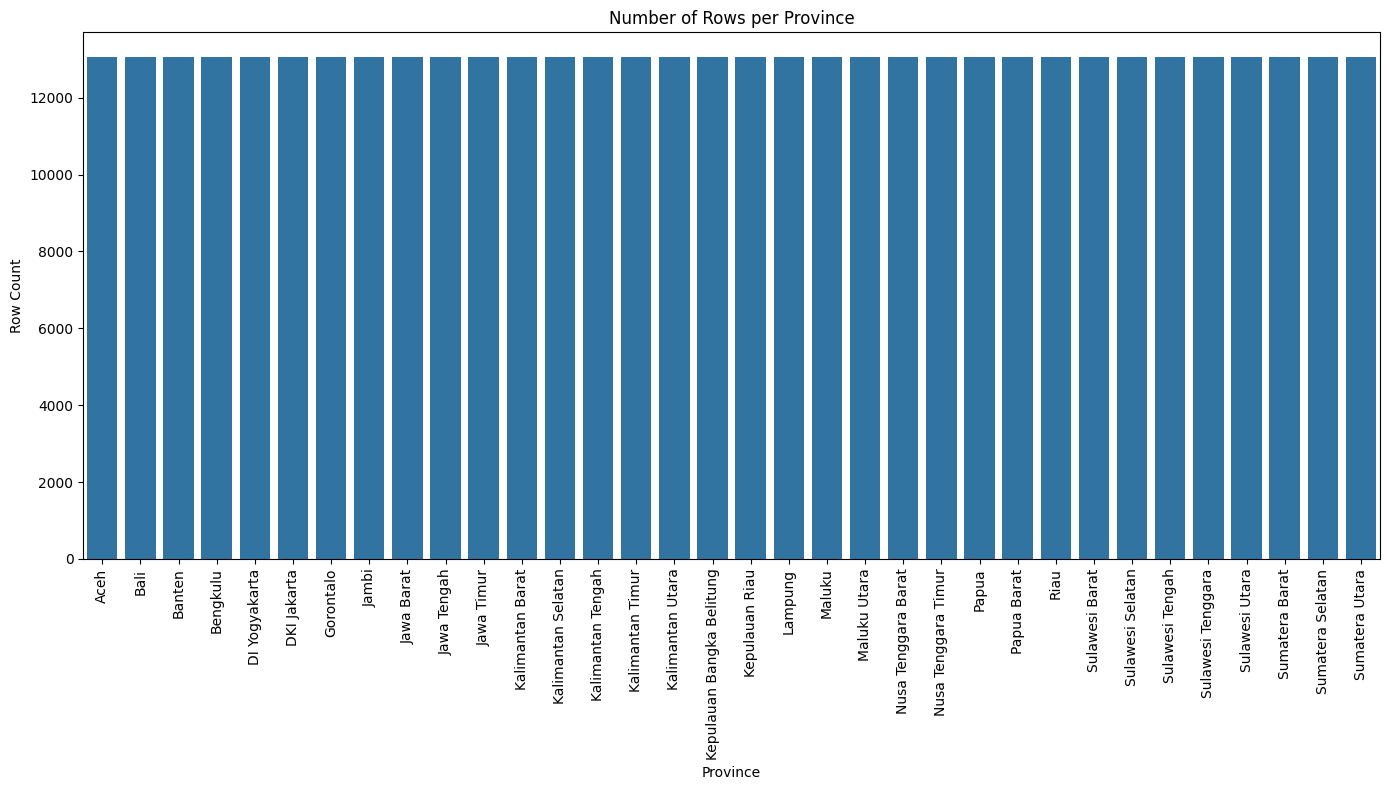

In [ ]:
print("\nMerging all provincial data...")
all_imputed = []

merge_progress = []

for p_file in os.listdir("imputed_data"):
    if p_file.endswith(".csv"):
        province_name = p_file.replace(".csv", "").replace("_", " ")
        try:
            file_path = f"imputed_data/{p_file}"
            df = pd.read_csv(file_path)
            all_imputed.append(df)
            merge_progress.append({
                'province': province_name,
                'status': 'Merged',
                'rows': len(df)
            })
            print(f"Added: {province_name} ({len(df)} rows)")
        except Exception as e:
            merge_progress.append({
                'province': province_name,
                'status': f"Error: {str(e)}",
                'rows': 0
            })
            print(f"Error merging {province_name}: {str(e)}")

if all_imputed:
    final_df = pd.concat(all_imputed, ignore_index=True)
    
    final_df.to_csv("final_imputed_data.csv", index=False)
    print(f"\nMerged data saved. Total rows: {len(final_df)}")
    
    merge_report = pd.DataFrame(merge_progress)
    merge_report.to_csv("merge_report.csv", index=False)
    
    print("\nSummary of results:")
    print(f"Total provinces: {len(merge_report)}")
    print(f"Successfully merged provinces: {len(merge_report[merge_report['status'] == 'Merged'])}")
    print(f"Provinces with errors: {len(merge_report[merge_report['status'].str.startswith('Error')])}")
    
    plt.figure(figsize=(14, 8))
    success_df = merge_report[merge_report['status'] == 'Merged']
    sns.barplot(data=success_df, x='province', y='rows')
    plt.title('Number of Rows per Province')
    plt.ylabel('Row Count')
    plt.xlabel('Province')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo data was successfully merged.")


Final validation:
Total rows: 443768
Final missing values: 0

Sorting data...

Sample final data (sorted):
              Date             province              food_item     price  price_final
42263   2022-08-28             Bengkulu           Bawang Merah   32310.0      32310.0
300130  2024-09-25  Nusa Tenggara Timur  Tepung Terigu (Curah)   10710.0      10710.0
379617  2022-03-27    Sulawesi Tenggara   Cabai Merah Keriting   51560.0      51560.0
436097  2023-02-18       Sumatera Utara  Tepung Terigu (Curah)   10780.0      10780.0
442956  2024-07-30       Sumatera Utara      Daging Sapi Murni  134910.0     134910.0

Final data saved to: final_imputed_data_sorted.csv


C:\Users\Kelvin Jonathan\AppData\Local\Temp\ipykernel_17220\604726825.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


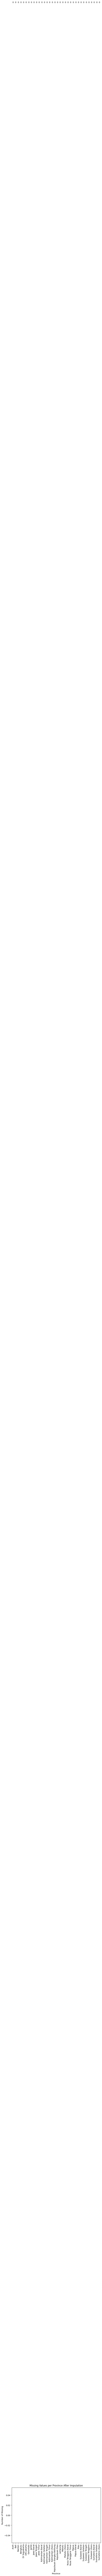

Missing values report per province saved to: missing_values_report.csv

Additional analysis:

Missing values per food item:
                          Food Item  Missing Values
0                      Bawang Merah               0
1              Bawang Putih Bonggol               0
2                      Beras Medium               0
3                     Beras Premium               0
4              Cabai Merah Keriting               0
5                 Cabai Rawit Merah               0
6                   Daging Ayam Ras               0
7                 Daging Sapi Murni               0
8                     Gula Konsumsi               0
9               Minyak Goreng Curah               0
10  Minyak Goreng Kemasan Sederhana               0
11                   Telur Ayam Ras               0
12            Tepung Terigu (Curah)               0

Missing values per date:
            Date  Missing Values
994   2024-09-21               0
995   2024-09-22               0
996   2024-09-23       

In [ ]:
if 'final_df' in locals() or 'final_df' in globals():
    print("\nFinal validation:")
    print(f"Total rows: {len(final_df)}")
    print(f"Final missing values: {final_df['price_final'].isnull().sum()}")
    
    print("\nSorting data...")
    final_df_sorted = final_df.sort_values(by=['Date', 'province', 'food_item'])
    
    print("\nSample final data (sorted):")
    print(final_df_sorted.sample(5)[['Date', 'province', 'food_item', 'price', 'price_final']])
    
    output_file = "final_imputed_data_sorted.csv"
    final_df_sorted.to_csv(output_file, index=False)
    print(f"\nFinal data saved to: {output_file}")
    
    missing_per_province = final_df_sorted.groupby('province')['price_final'].apply(
        lambda x: x.isnull().sum()
    ).reset_index()
    missing_per_province.columns = ['Province', 'Missing Values']
    
    plt.figure(figsize=(8, 5))
    sns.barplot(data=missing_per_province, x='Province', y='Missing Values')
    plt.title('Missing Values per Province After Imputation')
    plt.ylabel('Number of Missing')
    plt.xlabel('Province')
    plt.xticks(rotation=90)
    
    for i, row in enumerate(missing_per_province.itertuples()):
        plt.text(i, row._2 + 5, str(row._2), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('missing_per_province_final.png', dpi=300)
    plt.show()
    
    missing_per_province.to_csv("missing_values_report.csv", index=False)
    print("Missing values report per province saved to: missing_values_report.csv")
    
    print("\nAdditional analysis:")
    missing_per_food = final_df_sorted.groupby('food_item')['price_final'].apply(
        lambda x: x.isnull().sum()
    ).reset_index()
    missing_per_food.columns = ['Food Item', 'Missing Values']
    print("\nMissing values per food item:")
    print(missing_per_food)
    
    missing_per_date = final_df_sorted.groupby('Date')['price_final'].apply(
        lambda x: x.isnull().sum()
    ).reset_index()
    missing_per_date.columns = ['Date', 'Missing Values']
    print("\nMissing values per date:")
    print(missing_per_date.tail(10))  

else:
    print("\nError: final_df not found!")
    print("Make sure you have run the province data merging process")

print("\nProcess completed!")

## Model Development

### Cleaning Data

In [ ]:
print("\n" + "="*80)
print("PROCESSING IMPUTED DATA & PREPARING FOR MODELING")
print("="*80)

print("\nLoading imputed data from all provinces...")
all_imputed = []

for province_file in tqdm(os.listdir("imputed_data"), desc="Loading province files"):
    if province_file.endswith(".csv"):
        file_path = os.path.join("imputed_data", province_file)
        df = pd.read_csv(file_path)
        all_imputed.append(df)

imputed_df = pd.concat(all_imputed, ignore_index=True)
print(f"\nCombined data shape: {imputed_df.shape}")

imputed_df = imputed_df[['Date', 'province', 'food_item', 'price_final']]
imputed_df = imputed_df.rename(columns={'price_final': 'price'})

processed_dir = "processed_train"
os.makedirs(processed_dir, exist_ok=True)
print(f"\nCreated directory: {processed_dir}")

food_items = [
    'Bawang Merah', 'Bawang Putih Bonggol', 'Beras Medium', 'Beras Premium',
    'Cabai Merah Keriting', 'Cabai Rawit Merah', 'Daging Ayam Ras', 'Daging Sapi Murni',
    'Gula Konsumsi', 'Minyak Goreng Curah', 'Minyak Goreng Kemasan Sederhana',
    'Telur Ayam Ras', 'Tepung Terigu (Curah)'
]


PROCESSING IMPUTED DATA & PREPARING FOR MODELING

Loading imputed data from all provinces...


Loading province files: 100%|██████████| 34/34 [00:04<00:00,  7.71it/s]



Combined data shape: (443768, 79)

Created directory: processed_train


In [ ]:
print("\nProcessing and saving data per commodity:")

for food in tqdm(food_items, desc="Commodities"):
    food_df = imputed_df[imputed_df['food_item'] == food]
    
    pivot_df = food_df.pivot_table(
        index='Date',
        columns='province',
        values='price',
        aggfunc='mean'  
    ).reset_index()
    
    provinces_sorted = sorted(pivot_df.columns[1:])
    pivot_df = pivot_df[['Date'] + provinces_sorted]
    
    filename = f"{food}.csv"
    filepath = os.path.join(processed_dir, filename)
    pivot_df.to_csv(filepath, index=False)
    
    print(f"  Saved: {filename} ({len(pivot_df)} rows)")

print("\nVerification:")
print(f"Total commodities processed: {len(food_items)}")
print("Folder structure created:")
print(f"  {processed_dir}/")
for food in food_items:
    print(f"    ├── {food}.csv")

print("\nSample file content (Beras Medium.csv):")
beras_medium_df = pd.read_csv(os.path.join(processed_dir, "Beras Medium.csv"))


Processing and saving data per commodity:


Commodities:   8%|▊         | 1/13 [00:00<00:01,  9.32it/s]

  Saved: Bawang Merah.csv (1004 rows)
  Saved: Bawang Putih Bonggol.csv (1004 rows)

Commodities:  15%|█▌        | 2/13 [00:00<00:01,  9.56it/s]


  Saved: Beras Medium.csv (1004 rows)


Commodities:  31%|███       | 4/13 [00:00<00:00, 10.89it/s]

  Saved: Beras Premium.csv (1004 rows)


Commodities:  46%|████▌     | 6/13 [00:00<00:00, 10.73it/s]

  Saved: Cabai Merah Keriting.csv (1004 rows)
  Saved: Cabai Rawit Merah.csv (1004 rows)
  Saved: Daging Ayam Ras.csv (1004 rows)


Commodities:  62%|██████▏   | 8/13 [00:00<00:00, 11.12it/s]

  Saved: Daging Sapi Murni.csv (1004 rows)
  Saved: Gula Konsumsi.csv (1004 rows)


Commodities:  77%|███████▋  | 10/13 [00:00<00:00, 11.38it/s]

  Saved: Minyak Goreng Curah.csv (1004 rows)


Commodities:  92%|█████████▏| 12/13 [00:01<00:00, 11.02it/s]

  Saved: Minyak Goreng Kemasan Sederhana.csv (1004 rows)
  Saved: Telur Ayam Ras.csv (1004 rows)


Commodities: 100%|██████████| 13/13 [00:01<00:00, 10.91it/s]

  Saved: Tepung Terigu (Curah).csv (1004 rows)

Verification:
Total commodities processed: 13
Folder structure created:
  processed_train/
    ├── Bawang Merah.csv
    ├── Bawang Putih Bonggol.csv
    ├── Beras Medium.csv
    ├── Beras Premium.csv
    ├── Cabai Merah Keriting.csv
    ├── Cabai Rawit Merah.csv
    ├── Daging Ayam Ras.csv
    ├── Daging Sapi Murni.csv
    ├── Gula Konsumsi.csv
    ├── Minyak Goreng Curah.csv
    ├── Minyak Goreng Kemasan Sederhana.csv
    ├── Telur Ayam Ras.csv
    ├── Tepung Terigu (Curah).csv

Sample file content (Beras Medium.csv):


In [5]:
beras_medium_df.head(3)

,Date,Aceh,Bali,Banten,Bengkulu,DI Yogyakarta,DKI Jakarta,Gorontalo,Jambi,Jawa Barat,Jawa Tengah,Jawa Timur,Kalimantan Barat,Kalimantan Selatan,Kalimantan Tengah,Kalimantan Timur,Kalimantan Utara,Kepulauan Bangka Belitung,Kepulauan Riau,Lampung,Maluku,Maluku Utara,Nusa Tenggara Barat,Nusa Tenggara Timur,Papua,Papua Barat,Riau,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tenggara,Sulawesi Utara,Sumatera Barat,Sumatera Selatan,Sumatera Utara
0,2022-01-01,11030.0,10290.0,9960.0,10100.0,9650.0,11270.0,10190.0,9990.0,10140.0,10130.0,9910.0,12300.0,12750.0,12110.0,11850.0,12640.0,10240.0,12380.0,10340.0,11900.0,12790.0,9860.0,11310.0,12390.0,13000.0,12560.0,9880.0,9550.0,10070.0,10220.0,10940.0,12250.0,10360.0,11290.0
1,2022-01-02,10950.0,10320.0,9800.0,10130.0,9650.0,11010.0,10120.0,10110.0,10160.0,10180.0,9880.0,12390.0,11550.0,12170.0,11710.0,12640.0,10240.0,13170.0,10240.0,12230.0,12740.0,9970.0,11390.0,12950.0,12970.0,12630.0,9980.0,9570.0,9940.0,10090.0,10950.0,12210.0,10370.0,11400.0
2,2022-01-03,10970.0,10340.0,10040.0,10170.0,9610.0,11010.0,10190.0,10080.0,10170.0,10230.0,9870.0,12320.0,11730.0,12110.0,11750.0,12640.0,10240.0,13140.0,10290.0,12690.0,12710.0,9860.0,10930.0,12910.0,12780.0,12490.0,9810.0,9540.0,10180.0,10100.0,10890.0,12100.0,10320.0,11360.0


### Model Create

In [ ]:
INPUT_DIR = "processed_train"
OUTPUT_DIR = "predictions"
LOOK_BACK = 360  
FORECAST_DAYS = 92  
EPOCHS = 200
BATCH_SIZE = 128

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
def create_lstm_model(input_shape):
    model = Sequential()
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
                     input_shape=input_shape, padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Bidirectional(LSTM(256, return_sequences=True, 
                                kernel_regularizer=l2(0.001),
                                input_shape=input_shape)))
    model.add(Dropout(0.3))
    
    model.add(Bidirectional(LSTM(128, return_sequences=True, 
                                kernel_regularizer=l2(0.001))))
    model.add(Dropout(0.3))
    
    model.add(Bidirectional(LSTM(64, return_sequences=False, 
                                kernel_regularizer=l2(0.001))))
    model.add(Dropout(0.2))
    
    model.add(Dense(64, activation='relu'))

    model.add(Dense(34))
    
    optimizer = Adam(learning_rate=0.0005, clipvalue=0.5)
    
    model.compile(
        optimizer=optimizer,
        loss='huber_loss',  
        metrics=['mae', 'mse']
    )

    
    return model

def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

In [ ]:
def parse_dates(date_str):
    try:
        return datetime.strptime(date_str, '%m/%d/%Y')
    except ValueError:
        try:
            return datetime.strptime(date_str, '%Y-%m-%d')
        except ValueError:
            return pd.to_datetime(date_str, errors='coerce')

In [ ]:
def forecast_future(model, last_data, scaler, days=92):
    predictions = []
    current_batch = last_data.reshape(1, LOOK_BACK, last_data.shape[1])
    
    for _ in range(days):
        current_pred = model.predict(current_batch, verbose=0)[0]
        
        predictions.append(current_pred)
        
        current_pred_reshaped = current_pred.reshape(1, 1, -1)
        
        current_batch = np.concatenate(
            [current_batch[:, 1:, :], current_pred_reshaped],
            axis=1
        )
    
    predictions = np.array(predictions)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions

### Main Process Loop

In [ ]:
print("\n" + "="*80)
print("COMMODITY PRICE FORECASTING SYSTEM")
print("="*80)

commodity_files = [f for f in os.listdir(INPUT_DIR) if f.endswith('.csv')]

for commodity_file in tqdm(commodity_files, desc="Processing Commodities"):
    commodity_name = commodity_file.replace('.csv', '')
    print(f"\nProcessing: {commodity_name}")
    
    file_path = os.path.join(INPUT_DIR, commodity_file)
    df = pd.read_csv(file_path)
    
    df['Date'] = df['Date'].apply(parse_dates)
    
    df = df.sort_values('Date').dropna(subset=['Date'])
    
    provinces = df.columns[1:]
    last_date = df['Date'].max()
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[provinces])
    
    X, y = create_dataset(scaled_data, LOOK_BACK)
    
    if len(X) > 0:
        split = int(0.9 * len(X))
        X_train, X_val = X[:split], X[split:]
        y_train, y_val = y[:split], y[split:]
    else:
        print(f"⚠️ Not enough data for {commodity_name}. Skipping...")
        continue
    
    model = create_lstm_model((LOOK_BACK, len(provinces)))
    
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    print(f"Training model for {commodity_name}...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=1
    )
    

    last_data = scaled_data[-LOOK_BACK:]
    
    print(f"Forecasting future prices for {commodity_name}...")
    predictions = forecast_future(model, last_data, scaler, FORECAST_DAYS)
    
    prediction_dates = [last_date + timedelta(days=i) for i in range(1, FORECAST_DAYS + 1)]
    prediction_dates = [d.strftime('%m/%d/%Y') for d in prediction_dates]
    
    result_df = pd.DataFrame(predictions, columns=provinces)
    result_df.insert(0, 'Date', prediction_dates)
    
    output_path = os.path.join(OUTPUT_DIR, commodity_file)
    result_df.to_csv(output_path, index=False)
    
    print(f"✅ Forecast saved: {output_path}")
    

print("\n" + "="*80)
print("FORECASTING COMPLETED!")
print("="*80)
print(f"Forecasts saved to: {OUTPUT_DIR}/")
print(f"Total commodities processed: {len(commodity_files)}")


COMMODITY PRICE FORECASTING SYSTEM


Processing Commodities:   0%|          | 0/13 [00:00<?, ?it/s]


Processing: Bawang Merah
Training model for Bawang Merah...
Epoch 1/200
5/5 [==============================] - 18s 1s/step - loss: 1.7930 - mae: 0.2932 - mse: 0.1297 - val_loss: 1.6495 - val_mae: 0.0969 - val_mse: 0.0175
Epoch 2/200
5/5 [==============================] - 1s 298ms/step - loss: 1.6345 - mae: 0.2157 - mse: 0.0839 - val_loss: 1.5150 - val_mae: 0.0946 - val_mse: 0.0151
Epoch 3/200
5/5 [==============================] - 1s 305ms/step - loss: 1.4924 - mae: 0.1910 - mse: 0.0618 - val_loss: 1.3893 - val_mae: 0.0987 - val_mse: 0.0169
Epoch 4/200
5/5 [==============================] - 1s 277ms/step - loss: 1.3614 - mae: 0.1693 - mse: 0.0477 - val_loss: 1.2684 - val_mae: 0.0850 - val_mse: 0.0131
Epoch 5/200
5/5 [==============================] - 1s 275ms/step - loss: 1.2397 - mae: 0.1461 - mse: 0.0365 - val_loss: 1.1568 - val_mae: 0.0764 - val_mse: 0.0116
Epoch 6/200
5/5 [==============================] - 1s 269ms/step - loss: 1.1273 - mae: 0.1270 - mse: 0.0274 - val_loss: 1.0538

Processing Commodities:   8%|▊         | 1/13 [03:18<39:39, 198.25s/it]

✅ Forecast saved: predictions\Bawang Merah.csv

Processing: Bawang Putih Bonggol
Training model for Bawang Putih Bonggol...
Epoch 1/200
5/5 [==============================] - 17s 996ms/step - loss: 1.9004 - mae: 0.5240 - mse: 0.3321 - val_loss: 1.7930 - val_mae: 0.4747 - val_mse: 0.2828
Epoch 2/200
5/5 [==============================] - 1s 255ms/step - loss: 1.7125 - mae: 0.3851 - mse: 0.2135 - val_loss: 1.6157 - val_mae: 0.3471 - val_mse: 0.1816
Epoch 3/200
5/5 [==============================] - 1s 274ms/step - loss: 1.5581 - mae: 0.3196 - mse: 0.1546 - val_loss: 1.4615 - val_mae: 0.2657 - val_mse: 0.1166
Epoch 4/200
5/5 [==============================] - 1s 271ms/step - loss: 1.4203 - mae: 0.2744 - mse: 0.1180 - val_loss: 1.3267 - val_mae: 0.2261 - val_mse: 0.0783
Epoch 5/200
5/5 [==============================] - 1s 278ms/step - loss: 1.2917 - mae: 0.2341 - mse: 0.0870 - val_loss: 1.2039 - val_mae: 0.1857 - val_mse: 0.0493
Epoch 6/200
5/5 [==============================] - 1s 250ms/

Processing Commodities:  15%|█▌        | 2/13 [07:00<38:57, 212.51s/it]

✅ Forecast saved: predictions\Bawang Putih Bonggol.csv

Processing: Beras Medium
Training model for Beras Medium...
Epoch 1/200
5/5 [==============================] - 16s 958ms/step - loss: 1.8566 - mae: 0.4285 - mse: 0.2526 - val_loss: 1.7684 - val_mae: 0.3828 - val_mse: 0.2615
Epoch 2/200
5/5 [==============================] - 1s 253ms/step - loss: 1.6787 - mae: 0.2995 - mse: 0.1651 - val_loss: 1.6099 - val_mae: 0.3329 - val_mse: 0.1979
Epoch 3/200
5/5 [==============================] - 1s 256ms/step - loss: 1.5326 - mae: 0.2613 - mse: 0.1269 - val_loss: 1.4649 - val_mae: 0.2664 - val_mse: 0.1545
Epoch 4/200
5/5 [==============================] - 1s 265ms/step - loss: 1.3984 - mae: 0.2281 - mse: 0.1010 - val_loss: 1.3336 - val_mae: 0.2330 - val_mse: 0.1243
Epoch 5/200
5/5 [==============================] - 1s 267ms/step - loss: 1.2748 - mae: 0.2042 - mse: 0.0820 - val_loss: 1.2101 - val_mae: 0.1933 - val_mse: 0.0935
Epoch 6/200
5/5 [==============================] - 1s 260ms/step - l

Processing Commodities:  23%|██▎       | 3/13 [09:17<29:40, 178.00s/it]

✅ Forecast saved: predictions\Beras Medium.csv

Processing: Beras Premium
Training model for Beras Premium...
Epoch 1/200
5/5 [==============================] - 15s 852ms/step - loss: 1.8823 - mae: 0.4872 - mse: 0.3039 - val_loss: 1.7968 - val_mae: 0.4842 - val_mse: 0.3018
Epoch 2/200
5/5 [==============================] - 1s 234ms/step - loss: 1.6894 - mae: 0.3308 - mse: 0.1794 - val_loss: 1.6112 - val_mae: 0.3397 - val_mse: 0.1865
Epoch 3/200
5/5 [==============================] - 1s 234ms/step - loss: 1.5401 - mae: 0.2861 - mse: 0.1333 - val_loss: 1.4565 - val_mae: 0.2711 - val_mse: 0.1222
Epoch 4/200
5/5 [==============================] - 1s 236ms/step - loss: 1.4003 - mae: 0.2367 - mse: 0.0938 - val_loss: 1.3185 - val_mae: 0.2130 - val_mse: 0.0776
Epoch 5/200
5/5 [==============================] - 1s 263ms/step - loss: 1.2726 - mae: 0.1946 - mse: 0.0644 - val_loss: 1.1937 - val_mae: 0.1725 - val_mse: 0.0446
Epoch 6/200
5/5 [==============================] - 1s 231ms/step - loss: 1

Processing Commodities:  31%|███       | 4/13 [13:29<31:04, 207.22s/it]

✅ Forecast saved: predictions\Beras Premium.csv

Processing: Cabai Merah Keriting
Training model for Cabai Merah Keriting...
Epoch 1/200
5/5 [==============================] - 14s 898ms/step - loss: 1.7886 - mae: 0.2964 - mse: 0.1279 - val_loss: 1.6640 - val_mae: 0.1837 - val_mse: 0.0592
Epoch 2/200
5/5 [==============================] - 1s 287ms/step - loss: 1.6240 - mae: 0.2168 - mse: 0.0776 - val_loss: 1.5231 - val_mae: 0.1795 - val_mse: 0.0497
Epoch 3/200
5/5 [==============================] - 1s 299ms/step - loss: 1.4814 - mae: 0.1900 - mse: 0.0598 - val_loss: 1.3879 - val_mae: 0.1504 - val_mse: 0.0368
Epoch 4/200
5/5 [==============================] - 1s 278ms/step - loss: 1.3494 - mae: 0.1677 - mse: 0.0473 - val_loss: 1.2617 - val_mae: 0.1225 - val_mse: 0.0252
Epoch 5/200
5/5 [==============================] - 1s 295ms/step - loss: 1.2281 - mae: 0.1527 - mse: 0.0395 - val_loss: 1.1492 - val_mae: 0.1186 - val_mse: 0.0236
Epoch 6/200
5/5 [==============================] - 1s 278ms

Processing Commodities:  38%|███▊      | 5/13 [16:16<25:41, 192.72s/it]

✅ Forecast saved: predictions\Cabai Merah Keriting.csv

Processing: Cabai Rawit Merah
Training model for Cabai Rawit Merah...
Epoch 1/200
5/5 [==============================] - 14s 1s/step - loss: 1.7872 - mae: 0.2858 - mse: 0.1248 - val_loss: 1.6815 - val_mae: 0.2575 - val_mse: 0.0962
Epoch 2/200
5/5 [==============================] - 1s 293ms/step - loss: 1.6288 - mae: 0.2334 - mse: 0.0907 - val_loss: 1.5321 - val_mae: 0.2229 - val_mse: 0.0733
Epoch 3/200
5/5 [==============================] - 1s 289ms/step - loss: 1.4850 - mae: 0.2082 - mse: 0.0738 - val_loss: 1.3958 - val_mae: 0.2037 - val_mse: 0.0610
Epoch 4/200
5/5 [==============================] - 2s 324ms/step - loss: 1.3525 - mae: 0.1914 - mse: 0.0629 - val_loss: 1.2700 - val_mae: 0.1848 - val_mse: 0.0523
Epoch 5/200
5/5 [==============================] - 2s 316ms/step - loss: 1.2292 - mae: 0.1753 - mse: 0.0528 - val_loss: 1.1518 - val_mae: 0.1625 - val_mse: 0.0411
Epoch 6/200
5/5 [==============================] - 1s 293ms/s

Processing Commodities:  46%|████▌     | 6/13 [18:43<20:40, 177.22s/it]

✅ Forecast saved: predictions\Cabai Rawit Merah.csv

Processing: Daging Ayam Ras
Training model for Daging Ayam Ras...
Epoch 1/200
5/5 [==============================] - 16s 1s/step - loss: 1.8161 - mae: 0.3679 - mse: 0.1769 - val_loss: 1.6856 - val_mae: 0.2241 - val_mse: 0.0908
Epoch 2/200
5/5 [==============================] - 1s 253ms/step - loss: 1.6544 - mae: 0.2786 - mse: 0.1247 - val_loss: 1.5431 - val_mae: 0.2077 - val_mse: 0.0720
Epoch 3/200
5/5 [==============================] - 1s 261ms/step - loss: 1.5116 - mae: 0.2505 - mse: 0.1008 - val_loss: 1.4091 - val_mae: 0.1780 - val_mse: 0.0568
Epoch 4/200
5/5 [==============================] - 1s 256ms/step - loss: 1.3788 - mae: 0.2251 - mse: 0.0825 - val_loss: 1.2853 - val_mae: 0.1655 - val_mse: 0.0467
Epoch 5/200
5/5 [==============================] - 1s 242ms/step - loss: 1.2554 - mae: 0.2022 - mse: 0.0674 - val_loss: 1.1700 - val_mae: 0.1477 - val_mse: 0.0374
Epoch 6/200
5/5 [==============================] - 1s 274ms/step - l

Processing Commodities:  54%|█████▍    | 7/13 [21:13<16:49, 168.27s/it]

✅ Forecast saved: predictions\Daging Ayam Ras.csv

Processing: Daging Sapi Murni
Training model for Daging Sapi Murni...
Epoch 1/200
5/5 [==============================] - 16s 1s/step - loss: 1.8336 - mae: 0.4137 - mse: 0.2076 - val_loss: 1.6808 - val_mae: 0.2135 - val_mse: 0.0726
Epoch 2/200
5/5 [==============================] - 1s 252ms/step - loss: 1.6394 - mae: 0.2320 - mse: 0.0832 - val_loss: 1.5290 - val_mae: 0.1429 - val_mse: 0.0283
Epoch 3/200
5/5 [==============================] - 1s 245ms/step - loss: 1.4955 - mae: 0.1813 - mse: 0.0513 - val_loss: 1.3977 - val_mae: 0.0925 - val_mse: 0.0145
Epoch 4/200
5/5 [==============================] - 1s 250ms/step - loss: 1.3668 - mae: 0.1529 - mse: 0.0378 - val_loss: 1.2779 - val_mae: 0.0777 - val_mse: 0.0097
Epoch 5/200
5/5 [==============================] - 1s 289ms/step - loss: 1.2476 - mae: 0.1337 - mse: 0.0290 - val_loss: 1.1657 - val_mae: 0.0560 - val_mse: 0.0051
Epoch 6/200
5/5 [==============================] - 1s 273ms/step -

Processing Commodities:  62%|██████▏   | 8/13 [24:17<14:26, 173.24s/it]

✅ Forecast saved: predictions\Daging Sapi Murni.csv

Processing: Gula Konsumsi
Training model for Gula Konsumsi...
Epoch 1/200
5/5 [==============================] - 19s 1s/step - loss: 1.8623 - mae: 0.4274 - mse: 0.2676 - val_loss: 1.8252 - val_mae: 0.5026 - val_mse: 0.3634
Epoch 2/200
5/5 [==============================] - 2s 340ms/step - loss: 1.6832 - mae: 0.3243 - mse: 0.1718 - val_loss: 1.6472 - val_mae: 0.4470 - val_mse: 0.2653
Epoch 3/200
5/5 [==============================] - 2s 316ms/step - loss: 1.5342 - mae: 0.2757 - mse: 0.1289 - val_loss: 1.4844 - val_mae: 0.3520 - val_mse: 0.1871
Epoch 4/200
5/5 [==============================] - 2s 350ms/step - loss: 1.3957 - mae: 0.2314 - mse: 0.0941 - val_loss: 1.3399 - val_mae: 0.2753 - val_mse: 0.1308
Epoch 5/200
5/5 [==============================] - 2s 338ms/step - loss: 1.2688 - mae: 0.1905 - mse: 0.0678 - val_loss: 1.2122 - val_mae: 0.2291 - val_mse: 0.0933
Epoch 6/200
5/5 [==============================] - 2s 334ms/step - loss:

Processing Commodities:  69%|██████▉   | 9/13 [34:54<21:13, 318.28s/it]

✅ Forecast saved: predictions\Gula Konsumsi.csv

Processing: Minyak Goreng Curah
Training model for Minyak Goreng Curah...
Epoch 1/200
5/5 [==============================] - 16s 990ms/step - loss: 1.7709 - mae: 0.2422 - mse: 0.0872 - val_loss: 1.6947 - val_mae: 0.2626 - val_mse: 0.1153
Epoch 2/200
5/5 [==============================] - 1s 251ms/step - loss: 1.6116 - mae: 0.1676 - mse: 0.0480 - val_loss: 1.5454 - val_mae: 0.2371 - val_mse: 0.0905
Epoch 3/200
5/5 [==============================] - 1s 245ms/step - loss: 1.4725 - mae: 0.1516 - mse: 0.0388 - val_loss: 1.4083 - val_mae: 0.2135 - val_mse: 0.0756
Epoch 4/200
5/5 [==============================] - 1s 240ms/step - loss: 1.3424 - mae: 0.1386 - mse: 0.0318 - val_loss: 1.2829 - val_mae: 0.2023 - val_mse: 0.0669
Epoch 5/200
5/5 [==============================] - 1s 257ms/step - loss: 1.2216 - mae: 0.1242 - mse: 0.0262 - val_loss: 1.1626 - val_mae: 0.1746 - val_mse: 0.0511
Epoch 6/200
5/5 [==============================] - 1s 284ms/s

Processing Commodities:  77%|███████▋  | 10/13 [37:40<13:33, 271.24s/it]

✅ Forecast saved: predictions\Minyak Goreng Curah.csv

Processing: Minyak Goreng Kemasan Sederhana
Training model for Minyak Goreng Kemasan Sederhana...
Epoch 1/200
5/5 [==============================] - 17s 1s/step - loss: 1.7407 - mae: 0.1512 - mse: 0.0341 - val_loss: 1.6398 - val_mae: 0.1152 - val_mse: 0.0183
Epoch 2/200
5/5 [==============================] - 1s 271ms/step - loss: 1.5885 - mae: 0.1040 - mse: 0.0169 - val_loss: 1.4988 - val_mae: 0.1060 - val_mse: 0.0157
Epoch 3/200
5/5 [==============================] - 1s 263ms/step - loss: 1.4490 - mae: 0.0855 - mse: 0.0116 - val_loss: 1.3648 - val_mae: 0.0860 - val_mse: 0.0105
Epoch 4/200
5/5 [==============================] - 1s 295ms/step - loss: 1.3193 - mae: 0.0733 - mse: 0.0086 - val_loss: 1.2415 - val_mae: 0.0814 - val_mse: 0.0088
Epoch 5/200
5/5 [==============================] - 1s 262ms/step - loss: 1.1993 - mae: 0.0646 - mse: 0.0068 - val_loss: 1.1271 - val_mae: 0.0701 - val_mse: 0.0067
Epoch 6/200
5/5 [=================

Processing Commodities:  85%|████████▍ | 11/13 [40:29<07:59, 239.82s/it]

✅ Forecast saved: predictions\Minyak Goreng Kemasan Sederhana.csv

Processing: Telur Ayam Ras
Training model for Telur Ayam Ras...
Epoch 1/200
5/5 [==============================] - 16s 934ms/step - loss: 1.9021 - mae: 0.5359 - mse: 0.3405 - val_loss: 1.7369 - val_mae: 0.3412 - val_mse: 0.1722
Epoch 2/200
5/5 [==============================] - 1s 264ms/step - loss: 1.7062 - mae: 0.3722 - mse: 0.2008 - val_loss: 1.5807 - val_mae: 0.2641 - val_mse: 0.1095
Epoch 3/200
5/5 [==============================] - 1s 269ms/step - loss: 1.5553 - mae: 0.3110 - mse: 0.1457 - val_loss: 1.4481 - val_mae: 0.2326 - val_mse: 0.0846
Epoch 4/200
5/5 [==============================] - 1s 251ms/step - loss: 1.4205 - mae: 0.2691 - mse: 0.1121 - val_loss: 1.3213 - val_mae: 0.1932 - val_mse: 0.0589
Epoch 5/200
5/5 [==============================] - 1s 255ms/step - loss: 1.2948 - mae: 0.2290 - mse: 0.0837 - val_loss: 1.2046 - val_mae: 0.1577 - val_mse: 0.0398
Epoch 6/200
5/5 [==============================] - 1s

Processing Commodities:  92%|█████████▏| 12/13 [43:49<03:47, 227.82s/it]

✅ Forecast saved: predictions\Telur Ayam Ras.csv

Processing: Tepung Terigu (Curah)
Training model for Tepung Terigu (Curah)...
Epoch 1/200
5/5 [==============================] - 18s 1s/step - loss: 1.9120 - mae: 0.5477 - mse: 0.3653 - val_loss: 1.7362 - val_mae: 0.3338 - val_mse: 0.1726
Epoch 2/200
5/5 [==============================] - 2s 332ms/step - loss: 1.7155 - mae: 0.3709 - mse: 0.2218 - val_loss: 1.5763 - val_mae: 0.2457 - val_mse: 0.0998
Epoch 3/200
5/5 [==============================] - 2s 330ms/step - loss: 1.5656 - mae: 0.3204 - mse: 0.1644 - val_loss: 1.4478 - val_mae: 0.2281 - val_mse: 0.0802
Epoch 4/200
5/5 [==============================] - 2s 343ms/step - loss: 1.4290 - mae: 0.2786 - mse: 0.1243 - val_loss: 1.3239 - val_mae: 0.2015 - val_mse: 0.0577
Epoch 5/200
5/5 [==============================] - 2s 304ms/step - loss: 1.3035 - mae: 0.2436 - mse: 0.0939 - val_loss: 1.2107 - val_mae: 0.1729 - val_mse: 0.0434
Epoch 6/200
5/5 [==============================] - 2s 311ms

Processing Commodities: 100%|██████████| 13/13 [48:11<00:00, 222.43s/it]

✅ Forecast saved: predictions\Tepung Terigu (Curah).csv

FORECASTING COMPLETED!
Forecasts saved to: predictions/
Total commodities processed: 13


### Submission

In [ ]:
PREDICTIONS_DIR = "predictions"
SUBMISSION_FILE = "submission.csv"
PROVINCES = [
    'Aceh', 'Bali', 'Banten', 'Bengkulu', 'DI Yogyakarta', 
    'DKI Jakarta', 'Gorontalo', 'Jambi', 'Jawa Barat', 
    'Jawa Tengah', 'Jawa Timur', 'Kalimantan Barat', 
    'Kalimantan Selatan', 'Kalimantan Tengah', 'Kalimantan Timur', 
    'Kalimantan Utara', 'Kepulauan Bangka Belitung', 'Kepulauan Riau', 
    'Lampung', 'Maluku', 'Maluku Utara', 'Nusa Tenggara Barat', 
    'Nusa Tenggara Timur', 'Papua', 'Papua Barat', 'Riau', 
    'Sulawesi Barat', 'Sulawesi Selatan', 'Sulawesi Tengah', 
    'Sulawesi Tenggara', 'Sulawesi Utara', 'Sumatera Barat', 
    'Sumatera Selatan', 'Sumatera Utara'
]
FOOD_ITEMS = [
    'Bawang Merah', 'Bawang Putih Bonggol', 'Beras Medium', 'Beras Premium',
    'Cabai Merah Keriting', 'Cabai Rawit Merah', 'Daging Ayam Ras', 'Daging Sapi Murni',
    'Gula Konsumsi', 'Minyak Goreng Curah', 'Minyak Goreng Kemasan Sederhana',
    'Telur Ayam Ras', 'Tepung Terigu (Curah)'
]

def create_submission(predictions_dir, output_file):
    submission_df = pd.DataFrame(columns=['id', 'price'])
    
    for food_item in tqdm(FOOD_ITEMS, desc="Processing Food Items"):
        file_name = f"{food_item}.csv"
        file_path = os.path.join(predictions_dir, file_name)
        
        if not os.path.exists(file_path):
            print(f"⚠️ File not found: {file_path}")
            continue
        
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"⚠️ Error reading {file_path}: {str(e)}")
            continue
        
        try:
            df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
        except:
            try:
                df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
            except Exception as e:
                print(f"⚠️ Date conversion error in {file_path}: {str(e)}")
                continue
        
        for province in PROVINCES:
            if province not in df.columns:
                print(f"⚠️ Province {province} not found in {file_path}")
                continue
            
            province_df = pd.DataFrame({
                'id': f"{food_item}/{province}/" + df['Date'],
                'price': df[province]
            })
            
            submission_df = pd.concat([submission_df, province_df], ignore_index=True)
    
    submission_df.to_csv(output_file, index=False)
    print(f"\n✅ Submission file saved: {output_file}")
    print(f"Total rows: {len(submission_df)}")

if __name__ == "__main__":
    print("\n" + "="*80)
    print("CREATING SUBMISSION FILE")
    print("="*80)
    
    if not os.path.exists(PREDICTIONS_DIR):
        print(f"⚠️ Predictions directory not found: {PREDICTIONS_DIR}")
        print("Please run the forecasting script first.")
    else:
        create_submission(PREDICTIONS_DIR, SUBMISSION_FILE)
        
        print("\nValidation:")
        try:
            sample_submission = pd.read_csv(SUBMISSION_FILE)
            print(f"Sample of submission file (first 5 rows):")
            print(sample_submission.head())
            
            expected_rows = len(FOOD_ITEMS) * len(PROVINCES) * 92
            print(f"\nExpected rows: {expected_rows}")
            print(f"Actual rows: {len(sample_submission)}")
            
            example_id = "Bawang Merah/Aceh/2024-10-01"
            example_row = sample_submission[sample_submission['id'] == example_id]
            if not example_row.empty:
                print(f"\nExample row for {example_id}:")
                print(example_row)
            else:
                print(f"\n⚠️ Example id {example_id} not found")
        except Exception as e:
            print(f"⚠️ Error validating submission file: {str(e)}")

    print("\n" + "="*80)
    print("PROCESS COMPLETED!")
    print("="*80)


CREATING SUBMISSION FILE


Processing Food Items:   0%|          | 0/13 [00:00<?, ?it/s]C:\Users\Kelvin Jonathan\AppData\Local\Temp\ipykernel_30316\829800416.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  submission_df = pd.concat([submission_df, province_df], ignore_index=True)
Processing Food Items: 100%|██████████| 13/13 [00:00<00:00, 13.91it/s]



✅ Submission file saved: submission.csv
Total rows: 40664

Validation:
Sample of submission file (first 5 rows):
                             id      price
0  Bawang Merah/Aceh/2024-10-01  26047.701
1  Bawang Merah/Aceh/2024-10-02  26162.246
2  Bawang Merah/Aceh/2024-10-03  26236.775
3  Bawang Merah/Aceh/2024-10-04  26316.630
4  Bawang Merah/Aceh/2024-10-05  26399.137

Expected rows: 40664
Actual rows: 40664

Example row for Bawang Merah/Aceh/2024-10-01:
                             id      price
0  Bawang Merah/Aceh/2024-10-01  26047.701

PROCESS COMPLETED!
